<a href="https://colab.research.google.com/github/ilirsheraj/Transformers/blob/main/Fine_Tunning_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

df_ = pd.read_csv("AirlineTweets.csv")
df_.head()

File ‘AirlineTweets.csv’ already there; not retrieving.



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Pick just text and sentiment, others are not interesting
df = df_[["airline_sentiment", "text"]].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


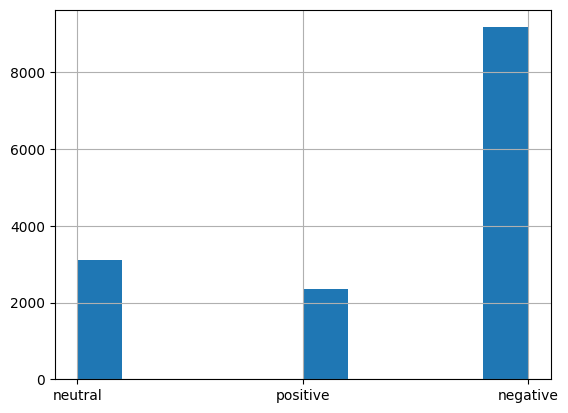

In [5]:
# Have a look at the sentiment distribution
df["airline_sentiment"].hist();

In [6]:
target_map = {"positive": 1, "negative": 0, "neutral": 2}
df["target"] = df["airline_sentiment"].map(target_map)
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [7]:
# Targets must have column label, otherwise it wont work
df2 = df[["text", "target"]]
df2.columns = ["sentence", "label"]
df2.to_csv("data.csv", index=None)

In [8]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [9]:
from datasets import load_dataset
# Load our dataset as hugging face dataset. This is fucking interesting
raw_dataset = load_dataset("csv", data_files="data.csv")
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [10]:
split = raw_dataset["train"].train_test_split(test_size=0.3, seed=42)
# Creates a dictionary like hugging face datasets
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [11]:
# If you have multiple csv files
# load_dataset("csv", data_files=["file1.csv", "file2.csv"])

# If you already have a train-test split in place
# load_dataset("csv",
#              data_files = {"train": ["train1.csv", "train2.csv"],
#                            "test": "test.csv"
#                            }
# )

In [11]:
checkpoint = "distilbert-base-cased"

In [12]:
from transformers import AutoTokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
def tokenize_fn(batch):
    return tokenizer(batch["sentence"], truncation=True)

In [15]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [16]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
!pip install torchinfo

In [18]:
from torchinfo import summary

In [19]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [21]:
#!pip install accelerate -U
# First install then restart colab, otherwise it will not work!

In [20]:
training_args = TrainingArguments(
    output_dir = "training_dir",
    evaluation_strategy= "epoch",
    save_strategy= "epoch",
    num_train_epochs= 3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64)

In [22]:
# define a compute metric function
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average = "macro")
    return {"accuracy": acc, "f1": f1}

In [23]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

In [24]:
# 3 hours in CPU, 3 min in GPU
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.531900,0.424142,0.833333,0.769662
2,0.340500,0.475914,0.834699,0.772649
3,0.216800,0.662039,0.833789,0.780448


TrainOutput(global_step=1923, training_loss=0.31603312975902825, metrics={'train_runtime': 206.5389, 'train_samples_per_second': 148.853, 'train_steps_per_second': 9.311, 'total_flos': 387616869956304.0, 'train_loss': 0.31603312975902825, 'epoch': 3.0})

In [25]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [26]:
from transformers import pipeline

In [27]:
# Pick the best performance here
savedmodel = pipeline("text-classification", model="training_dir/checkpoint-1282", device=0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
split["test"]

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [30]:
test_pred = savedmodel(split["test"]["sentence"])

In [32]:
test_pred[:2]

[{'label': 'LABEL_1', 'score': 0.9468333125114441},
 {'label': 'LABEL_1', 'score': 0.9595754742622375}]

In [34]:
def get_label(d):
    return int(d["label"].split("_")[1])

test_pred = [get_label(d) for d in test_pred]

In [35]:
print("acc: ", accuracy_score(split["test"]["label"], test_pred))

acc:  0.8346994535519126


In [36]:
print("f1: ", f1_score(split["test"]["label"], test_pred, average="macro"))

f1:  0.7726486717682333


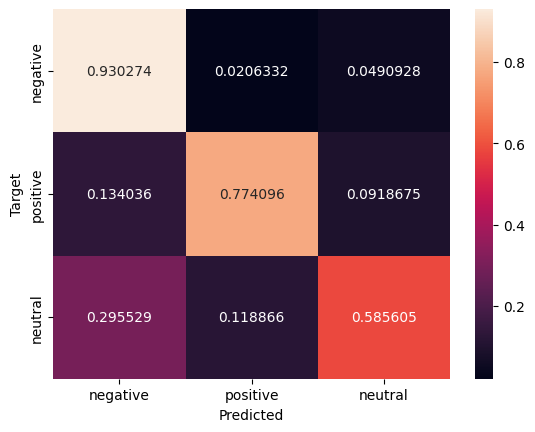

In [37]:
def plot_cm(cm):
    classes = ["negative", "positive", "neutral"]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt="g")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split["test"]["label"], test_pred, normalize="true")
plot_cm(cm)